In [ ]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
from interpolation.omega_gw_grid import OmegaGWGrid
from interpolation.omega_gw_jax import OmegaGWjax
from interpolation.model import Fixed_Nodes_Model
from interpolation.run import sampler
import pybobyqa
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=4,suppress=True)
jnp.set_printoptions(precision=4,suppress=True)
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


(50,)


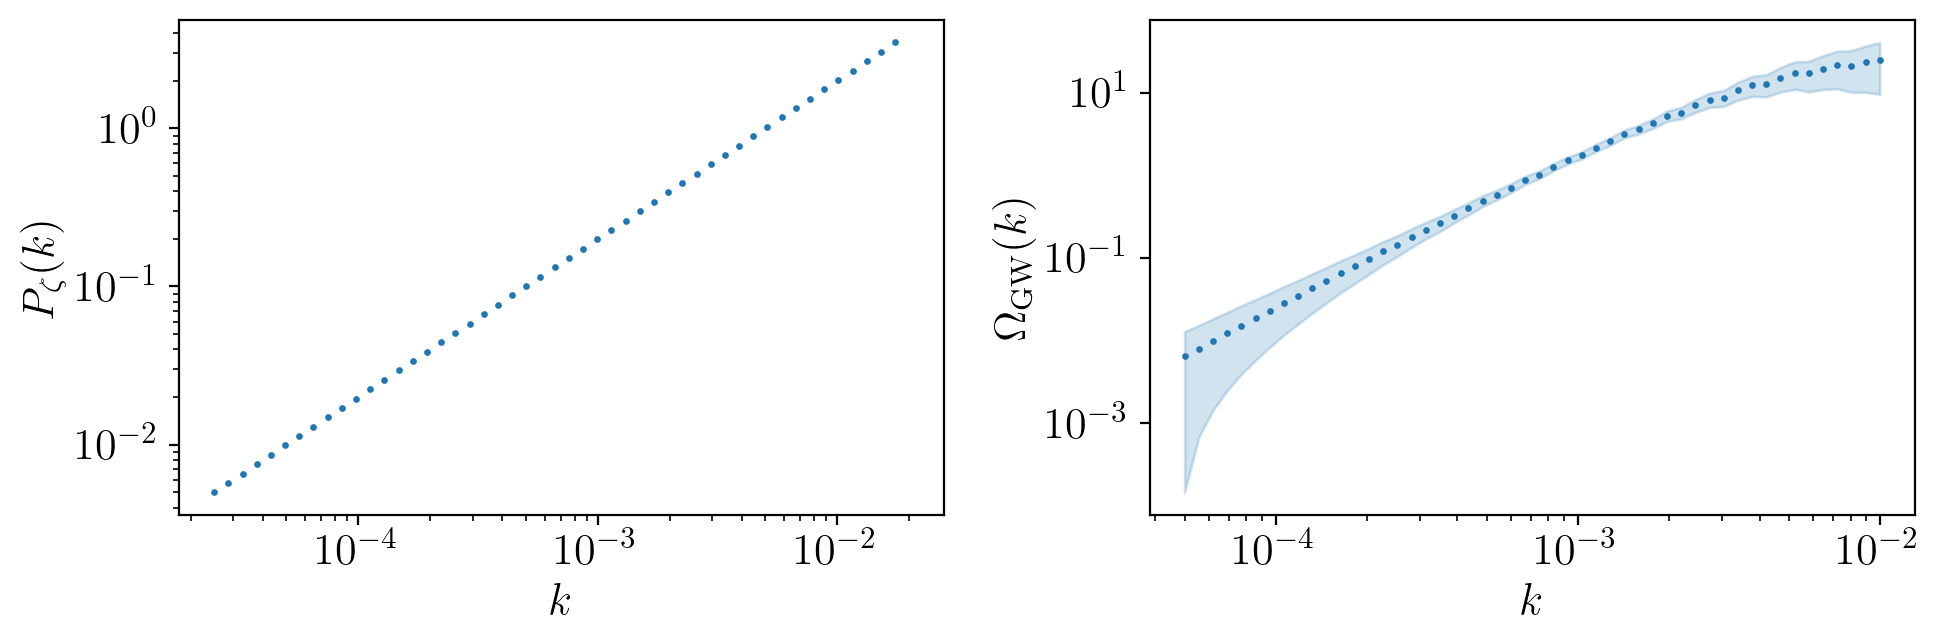

In [ ]:
# set up the power spectrum and omgw
psize = 50
ksize = 50
p_arr = jnp.geomspace(2.5e-5,2e-2,psize)
k_arr = jnp.geomspace(5e-5,1e-2,ksize)

f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 10)  # First rescaled internal momentum
t = jnp.logspace(-4,4, 100)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def pz_omega(p,pstar=5e-3,n1=1,pmin=2.5e-5,pmax=2e-2):
    res = (p/pstar)**n1
    res = jnp.where(p<pmin,0.,res)
    res = jnp.where(p>pmax,0.,res)
    return res

omgw_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)


pz_amp = pz_omega(p_arr)
omgw_amp = omgw_calculator(pz_omega,f)

print(omgw_amp.shape)
kstar = 1e-3
omks_sigma = omgw_amp*( 0.05*(np.log(k_arr/kstar))**2 + 0.05) # 2% error at kstar + more towards edges
omgw_cov = jnp.diag(omks_sigma**2)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(f,omgw_amp,s=2)
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

In [3]:
kmin, kmax = min(p_arr), max(p_arr)
omgw_method_kwargs = {'s': s, 't': t}
solver = sampler(pz_kmin=kmin,pz_kmax=kmax,omgw_karr=k_arr,
                 omgw_means=omgw_amp,omgw_cov=omgw_cov,
                 omgw_method='jax',omgw_method_kwargs=omgw_method_kwargs,
                y_low=-4,y_high=1,interpolation_method='CubicSpline',min_nodes=2,max_nodes=5)

In [4]:
results = solver.run()

sample: 100%|██████████| 1024/1024 [00:27<00:00, 37.90it/s, 7 steps of size 7.27e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -2.30      0.04     -2.30     -2.36     -2.25    305.00      1.00
      y[1]      0.60      0.01      0.60      0.58      0.62    303.57      1.00

Number of divergences: 0
First few samples: {'y': Array([[-2.3033,  0.6048],
       [-2.2857,  0.5924],
       [-2.2948,  0.6016],
       [-2.2256,  0.5763],
       [-2.3479,  0.6192]], dtype=float64)}
[-2.2982  0.6013]
Number of nodes: 2, chi2: -68.2242, aic: -64.2242, 'best_params': [-2.301   0.6021]


sample: 100%|██████████| 1024/1024 [00:47<00:00, 21.38it/s, 7 steps of size 5.61e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -2.38      0.20     -2.36     -2.70     -2.09    187.34      1.00
      y[1]     -0.85      0.01     -0.85     -0.88     -0.83    201.20      1.00
      y[2]      0.59      0.03      0.59      0.54      0.63    200.34      1.00

Number of divergences: 0
First few samples: {'y': Array([[-2.3103, -0.8531,  0.5994],
       [-2.6619, -0.8651,  0.5659],
       [-2.9505, -0.8838,  0.5299],
       [-2.422 , -0.835 ,  0.5612],
       [-2.25  , -0.8406,  0.5975]], dtype=float64)}
[-2.315  -0.8503  0.601 ]
Number of nodes: 3, chi2: -68.2242, aic: -62.2242, 'best_params': [-2.301  -0.8495  0.6021]


sample: 100%|██████████| 1024/1024 [01:33<00:00, 10.93it/s, 7 steps of size 1.65e-01. acc. prob=0.68] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -2.64      0.61     -2.58     -3.60     -1.71     60.71      1.00
      y[1]     -1.37      0.05     -1.36     -1.46     -1.28     85.76      1.00
      y[2]     -0.36      0.01     -0.36     -0.38     -0.34    186.26      1.00
      y[3]      0.61      0.06      0.61      0.51      0.71     98.01      1.00

Number of divergences: 11
First few samples: {'y': Array([[-2.8154, -1.3234, -0.387 ,  0.6759],
       [-2.4372, -1.2855, -0.3967,  0.6959],
       [-3.4632, -1.396 , -0.3525,  0.6607],
       [-3.2214, -1.4252, -0.3803,  0.6923],
       [-3.3475, -1.4057, -0.3804,  0.7013]], dtype=float64)}
[-2.2609 -1.3315 -0.3668  0.6026]
Number of nodes: 4, chi2: -68.2242, aic: -60.2242, 'best_params': [-2.301  -1.3333 -0.3656  0.6021]


sample: 100%|██████████| 1024/1024 [01:26<00:00, 11.81it/s, 54 steps of size 1.16e-03. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -0.53      0.00     -0.53     -0.54     -0.53      2.59      2.41
      y[1]     -1.11      0.01     -1.11     -1.12     -1.10      2.52      2.60
      y[2]     -1.80      0.00     -1.80     -1.81     -1.80      2.48      2.83
      y[3]     -3.31      0.00     -3.31     -3.32     -3.31      2.62      2.39
      y[4]      0.25      0.00      0.25      0.25      0.25      4.27      1.48

Number of divergences: 496
First few samples: {'y': Array([[-0.5268, -1.0992, -1.8012, -3.3163,  0.25  ],
       [-0.5268, -1.0992, -1.8012, -3.3163,  0.25  ],
       [-0.5268, -1.0992, -1.8011, -3.3163,  0.25  ],
       [-0.5268, -1.0992, -1.8011, -3.3163,  0.25  ],
       [-0.5268, -1.0992, -1.8011, -3.3163,  0.25  ]], dtype=float64)}
[-0.5407 -1.1252 -1.8063 -3.312   0.2487]
Number of nodes: 5, chi2: -68.2242, aic: -58.2242, 'best_params': [-2.301  -1.5753 -0.8495 -0.1237  0.6021]


(0.0001, 100.0)

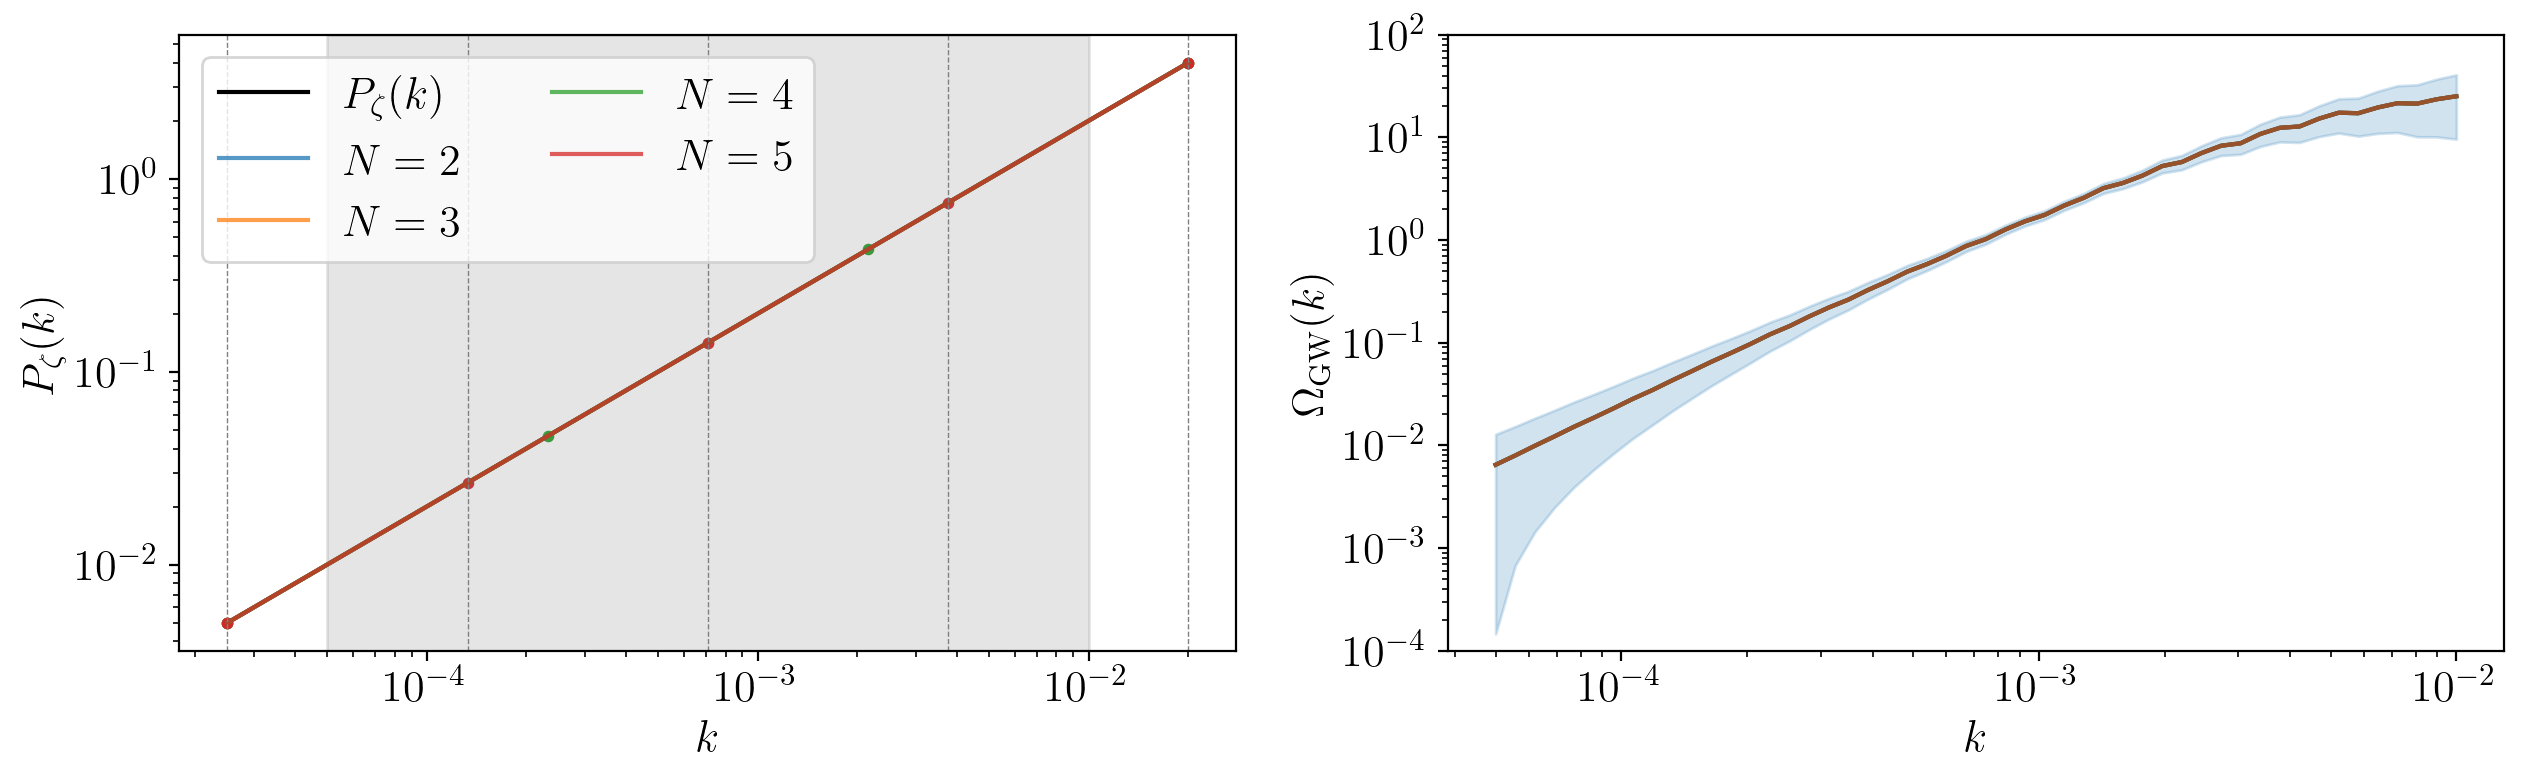

In [11]:
from interpolation.model import spline_predict

@jit
def pz_f(p,pstar=5e-3,n1=1,pmin=2.5e-5,pmax=2e-2):
    res = (p/pstar)**n1
    return res


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
pz_amp = pz_f(p_arr)
ax1.loglog(p_arr,pz_amp,label=r'$P_{\zeta}(k)$',color='k',lw=1.5)
ax2.loglog(f,omgw_amp,label=r'Truth',color='k',lw=1.5)
n_nodes = [2,3,4,5]#,6]
for n in n_nodes:
    res = results[str(n)]
    nodes = res['node_locations']
    best_params = res['best_params']
    def pz_bf(x):
        val = spline_predict(x_train=nodes,y_train=best_params,x_pred=x) #
        val = jnp.where(jnp.log10(x)<jnp.log10(kmin),0.,val)
        val = jnp.where(jnp.log10(x)>jnp.log10(kmax),0.,val)
        return val
    pz = pz_bf(p_arr)
    omgw_bf = omgw_calculator(pz_bf,k_arr) #jnp.einsum("i,j,kij->k",pz_bf,pz_bf,omgw_calculator.omkij)
    ax1.loglog(p_arr,pz,label=f'$N = {n}$',alpha=0.75)
    ax1.scatter(10**(nodes),10**(best_params),s=10)
    ax2.loglog(k_arr,omgw_bf,label=f'$N = {n}$',alpha=0.5)
for node in nodes:
    ax1.axvline(10**(node),color='gray',ls='--',lw=0.5)
for x in [ax1,ax2]:
    x.set(xlabel=r'$k$',yscale='log',xscale='log')
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax1.legend(ncol=2)
ax1.axvspan(min(k_arr),max(k_arr),color='gray',alpha=0.2)
ax2.set_ylim(1e-4,1e2)